In [1]:
import os
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import make_lupton_rgb
from matplotlib.colors import CenteredNorm, LogNorm

from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure
from mejiro.instruments.hst import HST
from mejiro.instruments.roman import Roman
from mejiro.instruments.lsst import LSST
from mejiro.instruments.hwo import HWO
from mejiro.utils import util

# read configuration file
with open('/grad/bwedig/mejiro/mejiro/data/mejiro_config/hwo.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

plt.style.use('/grad/bwedig/mejiro/mejiro/mejiro.mplstyle')

Warning, 5 of 20000 bins contained negative fluxes; they have been set to zero.


/data/bwedig/.conda/envs/mejiro-v2/lib/python3.10/site-packages/pysynphot/units.py:824: RuntimeWarning: divide by zero encountered in log
  return -1.085736 * N.log(arg) + ABZERO


Warning, 3590 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 293 of 2920 bins contained negative fluxes; they have been set to zero.


In [2]:
if config['dev']:
    config['pipeline_label'] += '_dev'

In [3]:
lens_dir = os.path.join(config['data_dir'], config['pipeline_label'], '02')
lenses = util.unpickle_all(lens_dir)
print(f'Found {len(lenses)} strong lens(es) in {lens_dir}')

name_snr_pairs = util.unpickle('/data/bwedig/mejiro/hwo/snr/name_snr_pairs.pkl')
snr_dict = dict(name_snr_pairs)

# Sort lenses by SNR, matching on exposure.synthetic_image.strong_lens.name
sorted_lenses = sorted(
    lenses,
    key=lambda lens: snr_dict.get(lens.name, -np.inf),
    reverse=True
)

Found 370 strong lens(es) in /data/bwedig/mejiro/hwo_dev/02


In [4]:
sample = lenses[22]

fov_arcsec = 3

In [5]:
hwo = HWO()
lsst = LSST()
hst = HST()

hwo_pixel_scale = hwo.get_pixel_scale('I')
hst_pixel_scale = hst.get_pixel_scale('F814W')
lsst_pixel_scale = lsst.get_pixel_scale('i')
print(f'Pixel scales: HWO {hwo_pixel_scale:.4f}"/pix, HST {hst_pixel_scale:.4f}"/pix, LSST {lsst_pixel_scale:.4f}"/pix')

hwo_psf_kwargs = hwo.get_psf_kwargs(band='I')
pprint(hwo_psf_kwargs)

hst_psf_kwargs = hst.get_psf_kwargs(band='F814W')
pprint(hst_psf_kwargs)

Pixel scales: HWO 0.0057 arcsec / pix"/pix, HST 0.0400 arcsec / pix"/pix, LSST 0.2000 arcsec / pix"/pix
{'fwhm': 0.02508122748185179, 'psf_type': 'GAUSSIAN'}
{'fwhm': 0.074, 'psf_type': 'GAUSSIAN'}


Scene size: 3.0 arcsec, 15 pixels at pixel scale 0.2 arcsec/pix
Synthetic image calculation time: 1.879 s
Exposure calculation time with lenstronomy engine: 0.011 s
Scene size: 3.0 arcsec, 75 pixels at pixel scale 0.04 arcsec/pix


/data/bwedig/.conda/envs/mejiro-v2/lib/python3.10/site-packages/lenstronomy/LensModel/MultiPlane/multi_plane.py:77: UserWarning: Cosmology is provided. Make sure your cosmological model is consistent with the cosmology_model argument.
  warnings.warn(
/grad/bwedig/mejiro/mejiro/utils/util.py:170: UserWarning: Negative values in array have been replaced with 0.031631999273179.
  warnings.warn(f"Negative values in array have been replaced with {replacement}.")


Synthetic image calculation time: 0.592 s
Exposure calculation time with galsim engine: 0.064 s
Scene size: 3.0080284244368225 arcsec, 525 pixels at pixel scale 0.005729577951308233 arcsec/pix


Synthetic image calculation time: 3.61 s
Exposure calculation time with galsim engine: 0.034 s


/tmp/ipykernel_3254483/2343341710.py:43: RuntimeWarning: invalid value encountered in log10
  ax[0, 2].imshow(np.log10(synthetic_image_hwo.image),cmap='cubehelix')


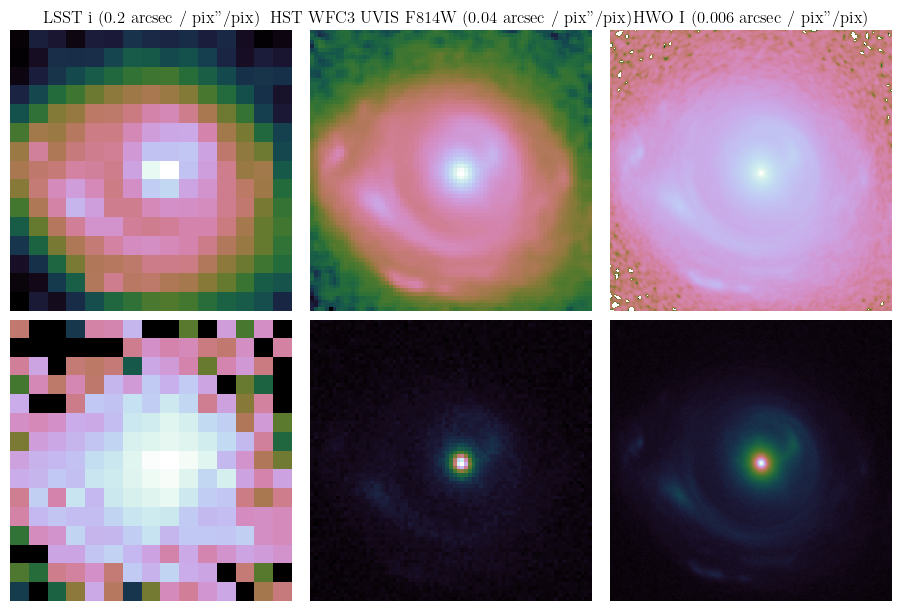

In [6]:
exposure_time = 1e5

synthetic_image_lsst = SyntheticImage(strong_lens=deepcopy(sample),
                                 instrument=lsst,
                                 band='i',
                                 fov_arcsec=fov_arcsec,
                                 verbose=True)
exposure_lsst = Exposure(synthetic_image=synthetic_image_lsst,
                        exposure_time=1,
                        engine='lenstronomy',
                        engine_params={'obs_config_kwargs': {
                        'band': 'i', 
                        'psf_type': 'GAUSSIAN', 
                        'coadd_years': 10
                    }},
                        verbose=True)

synthetic_image_hst = SyntheticImage(strong_lens=deepcopy(sample),
                                 instrument=hst,
                                 band='F814W',
                                 fov_arcsec=fov_arcsec,
                                 kwargs_psf=hst_psf_kwargs,
                                 verbose=True)
exposure_hst = Exposure(synthetic_image=synthetic_image_hst,
                        exposure_time=exposure_time,
                        engine='galsim',
                        verbose=True)

synthetic_image_hwo = SyntheticImage(strong_lens=deepcopy(sample),
                                     instrument=hwo,
                                     band='I',
                                     fov_arcsec=fov_arcsec,
                                     kwargs_psf=hwo_psf_kwargs,
                                     verbose=True)
exposure_hwo = Exposure(synthetic_image=synthetic_image_hwo,
                        exposure_time=exposure_time,
                        verbose=True)

f, ax = plt.subplots(2, 3, figsize=(9, 6), constrained_layout=True)

ax[0, 0].imshow(np.log10(synthetic_image_lsst.image),cmap='cubehelix')
ax[0, 1].imshow(np.log10(synthetic_image_hst.image),cmap='cubehelix')
ax[0, 2].imshow(np.log10(synthetic_image_hwo.image),cmap='cubehelix')

ax[0, 0].set_title(f'LSST i ({lsst_pixel_scale:.1f}"/pix)')
ax[0, 1].set_title(f'HST WFC3 UVIS F814W ({hst_pixel_scale:.2f}"/pix)')
ax[0, 2].set_title(f'HWO I ({hwo_pixel_scale:.3f}"/pix)')

ax[1, 0].imshow(np.log10(exposure_lsst.exposure),cmap='cubehelix')
ax[1, 1].imshow(np.log10(exposure_hst.exposure),cmap='cubehelix')
ax[1, 2].imshow(np.log10(exposure_hwo.exposure),cmap='cubehelix')

for a in ax.flatten():
    a.axis('off')
    
# plt.savefig('/grad/bwedig/mejiro/projects/hwo/figures/compare_instruments.png', dpi=600)
plt.show()

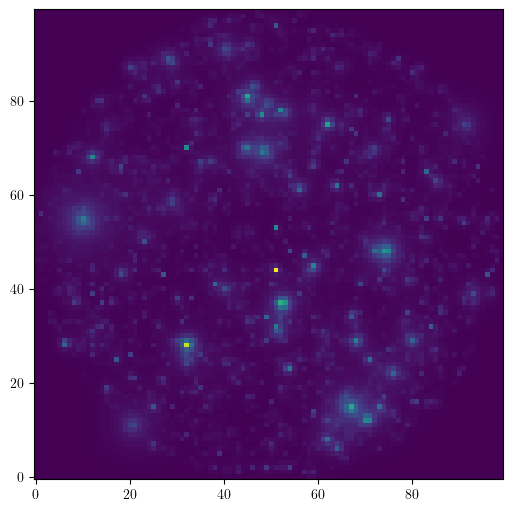

In [14]:
with_substructure = deepcopy(sample)
with_substructure.quick_add(model_kwargs={'LOS_normalization': 0., 'cone_opening_angle_arcsec': fov_arcsec})

plt.imshow(with_substructure.get_realization_kappa(fov_arcsec=3, num_pix=100))
plt.show()

Scene size: 3.0 arcsec, 15 pixels at pixel scale 0.2 arcsec/pix
Synthetic image calculation time: 0.88 s
Exposure calculation time with lenstronomy engine: 0.752 s
Scene size: 3.0 arcsec, 75 pixels at pixel scale 0.04 arcsec/pix
Synthetic image calculation time: 1.55 s
Exposure calculation time with galsim engine: 0.008 s
Scene size: 3.0080284244368225 arcsec, 525 pixels at pixel scale 0.005729577951308233 arcsec/pix
Synthetic image calculation time: 61.683 s
Exposure calculation time with galsim engine: 0.04 s


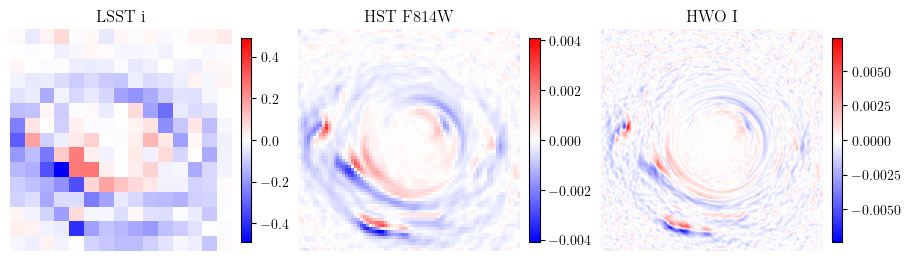

In [15]:
synthetic_image_lsst_with = SyntheticImage(strong_lens=with_substructure,
                                 instrument=lsst,
                                 band='i',
                                 fov_arcsec=fov_arcsec,
                                 verbose=True)
exposure_lsst_with = Exposure(synthetic_image=synthetic_image_lsst_with,
                    exposure_time=1,
                    engine='lenstronomy',
                    engine_params={'obs_config_kwargs': {
                    'band': 'i', 
                    'psf_type': 'GAUSSIAN', 
                    'coadd_years': 10
                }},
                    verbose=True)

synthetic_image_hst_with = SyntheticImage(strong_lens=with_substructure,
                                 instrument=hst,
                                 band='F814W',
                                 fov_arcsec=fov_arcsec,
                                 kwargs_psf=hst_psf_kwargs,
                                 verbose=True)
exposure_hst_with = Exposure(synthetic_image=synthetic_image_hst_with,
                    exposure_time=exposure_time,
                    engine='galsim',
                    verbose=True)

synthetic_image_hwo_with = SyntheticImage(strong_lens=with_substructure,
                                     instrument=hwo,
                                     band='I',
                                     fov_arcsec=fov_arcsec,
                                     kwargs_psf=hwo_psf_kwargs,
                                     verbose=True)
exposure_hwo_with = Exposure(synthetic_image=synthetic_image_hwo_with,
                        exposure_time=exposure_time,
                        verbose=True)

_, ax = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

im0 = ax[0].imshow(synthetic_image_lsst_with.image - synthetic_image_lsst.image, norm=CenteredNorm(), cmap='bwr')
ax[0].set_title('LSST i')
plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(synthetic_image_hst_with.image - synthetic_image_hst.image, norm=CenteredNorm(), cmap='bwr')
ax[1].set_title('HST F814W')
plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(synthetic_image_hwo_with.image - synthetic_image_hwo.image, norm=CenteredNorm(), cmap='bwr')
ax[2].set_title('HWO I')
plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

for a in ax.flatten():
    a.axis('off')

plt.show()

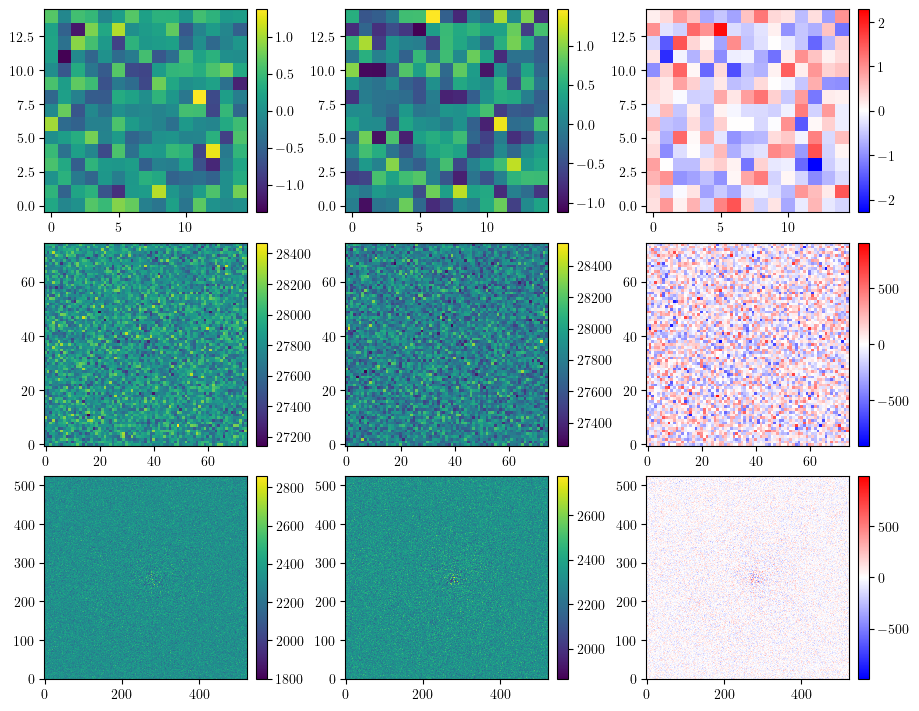

In [16]:
_, ax = plt.subplots(3, 3, figsize=(9, 7), constrained_layout=True)

im00 = ax[0,0].imshow(exposure_lsst_with.noise)
plt.colorbar(im00, ax=ax[0,0], fraction=0.046, pad=0.04)

im01 = ax[0,1].imshow(exposure_lsst.noise)
plt.colorbar(im01, ax=ax[0,1], fraction=0.046, pad=0.04)

im02 = ax[0,2].imshow(exposure_lsst_with.noise - exposure_lsst.noise, norm=CenteredNorm(), cmap='bwr')
plt.colorbar(im02, ax=ax[0,2], fraction=0.046, pad=0.04)

im10 = ax[1,0].imshow(exposure_hst_with.noise)
plt.colorbar(im10, ax=ax[1,0], fraction=0.046, pad=0.04)

im11 = ax[1,1].imshow(exposure_hst.noise)
plt.colorbar(im11, ax=ax[1,1], fraction=0.046, pad=0.04)

im12 = ax[1,2].imshow(exposure_hst_with.noise - exposure_hst.noise, norm=CenteredNorm(), cmap='bwr')
plt.colorbar(im12, ax=ax[1,2], fraction=0.046, pad=0.04)

im20 = ax[2,0].imshow(exposure_hwo_with.noise)
plt.colorbar(im20, ax=ax[2,0], fraction=0.046, pad=0.04)

im21 = ax[2,1].imshow(exposure_hwo.noise)
plt.colorbar(im21, ax=ax[2,1], fraction=0.046, pad=0.04)

im22 = ax[2,2].imshow(exposure_hwo_with.noise - exposure_hwo.noise, norm=CenteredNorm(), cmap='bwr')
plt.colorbar(im22, ax=ax[2,2], fraction=0.046, pad=0.04)

plt.show()

In [17]:
def mask_central_circle(image, radius_arcsec, pixel_scale, center=None, fill_value=np.nan):
    pix_radius = radius_arcsec / pixel_scale.value

    ny, nx = image.shape
    if center is None:
        cy, cx = ny // 2, nx // 2
    else:
        cy, cx = center

    y, x = np.indices((ny, nx))
    mask = ((x - cx) ** 2 + (y - cy) ** 2) <= (pix_radius ** 2)

    return np.where(mask, fill_value, image)

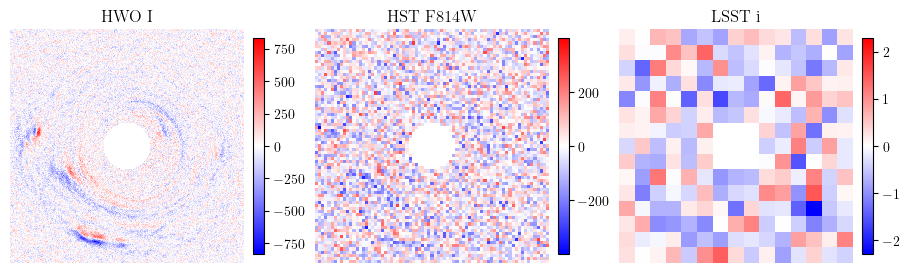

In [18]:
_, ax = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

radius_arcsec = 0.3

im0 = ax[0].imshow(mask_central_circle(exposure_hwo_with.exposure - exposure_hwo.exposure, radius_arcsec, hwo_pixel_scale), norm=CenteredNorm(), cmap='bwr')
ax[0].set_title('HWO I')
plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(mask_central_circle(exposure_hst_with.exposure - exposure_hst.exposure, radius_arcsec, hst_pixel_scale), norm=CenteredNorm(), cmap='bwr')
ax[1].set_title('HST F814W')
plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(mask_central_circle(exposure_lsst_with.exposure - exposure_lsst.exposure, radius_arcsec, lsst_pixel_scale), norm=CenteredNorm(), cmap='bwr')
ax[2].set_title('LSST i')
plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

for a in ax.flatten():
    a.axis('off')

plt.show()

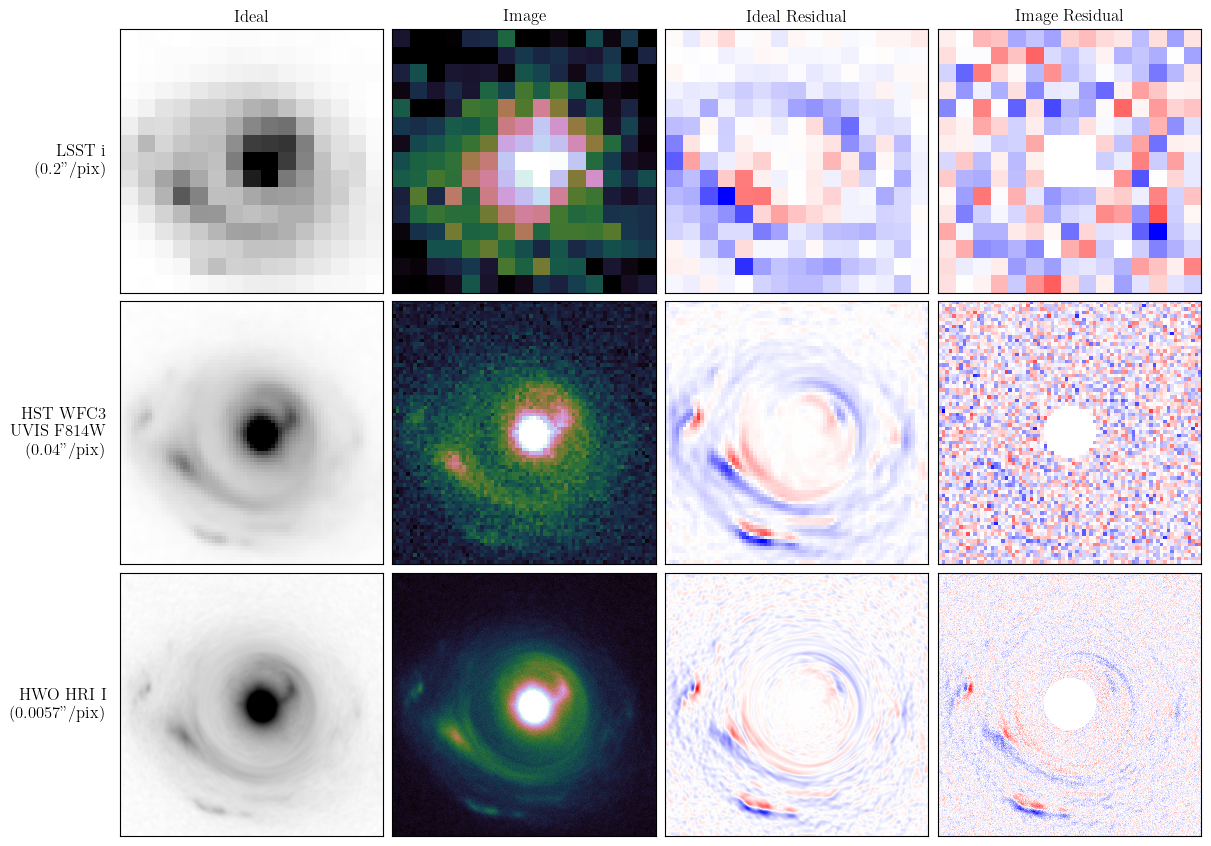

In [39]:
f, ax = plt.subplots(3, 4, figsize=(12, 8.35), constrained_layout=True)

# column titles (types)
col_titles = ['Ideal', 'Image', 'Ideal Residual', 'Image Residual']
for j, t in enumerate(col_titles):
    ax[0, j].set_title(t)

# row labels (instruments + pixel scales)
row_labels = [
    f'LSST i\n({lsst_pixel_scale.value:.1f}"/pix)',
    f'HST WFC3\nUVIS F814W\n({hst_pixel_scale.value:.2f}"/pix)',
    f'HWO HRI I\n({hwo_pixel_scale.value:.4f}"/pix)'
]
for i, lab in enumerate(row_labels):
    ax[i, 0].set_ylabel(lab, fontsize=12, rotation=0, labelpad=10, ha='right', va='center')
    ax[i, 0].yaxis.set_label_coords(-0.05, 0.5)

# Row 0: LSST
ax[0, 0].imshow(np.clip(synthetic_image_lsst.image, None, np.nanpercentile(synthetic_image_lsst.image, 99)), cmap='binary')
ax[0, 1].imshow(np.clip(exposure_lsst.exposure, None, np.nanpercentile(exposure_lsst.exposure, 99)), cmap='cubehelix')
ax[0, 2].imshow(synthetic_image_lsst_with.image - synthetic_image_lsst.image, norm=CenteredNorm(), cmap='bwr')
ax[0, 3].imshow(mask_central_circle(exposure_lsst_with.exposure - exposure_lsst.exposure, radius_arcsec, lsst_pixel_scale),
                norm=CenteredNorm(), cmap='bwr')

# Row 1: HST
ax[1, 0].imshow(np.clip(synthetic_image_hst.image, None, np.nanpercentile(synthetic_image_hst.image, 99)), cmap='binary')
ax[1, 1].imshow(np.clip(exposure_hst.exposure, None, np.nanpercentile(exposure_hst.exposure, 99)), cmap='cubehelix')
ax[1, 2].imshow(synthetic_image_hst_with.image - synthetic_image_hst.image, norm=CenteredNorm(), cmap='bwr')
ax[1, 3].imshow(mask_central_circle(exposure_hst_with.exposure - exposure_hst.exposure, radius_arcsec, hst_pixel_scale),
                norm=CenteredNorm(), cmap='bwr')

# Row 2: HWO
ax[2, 0].imshow(np.clip(synthetic_image_hwo.image, None, np.nanpercentile(synthetic_image_hwo.image, 99)), cmap='binary')
ax[2, 1].imshow(np.clip(exposure_hwo.exposure, None, np.nanpercentile(exposure_hwo.exposure, 99)), cmap='cubehelix')
ax[2, 2].imshow(synthetic_image_hwo_with.image - synthetic_image_hwo.image, norm=CenteredNorm(), cmap='bwr')
ax[2, 3].imshow(mask_central_circle(exposure_hwo_with.exposure - exposure_hwo.exposure, radius_arcsec, hwo_pixel_scale),
                norm=CenteredNorm(), cmap='bwr')

# clean up ticks
for a in ax.flatten():
    a.tick_params(axis='both', which='both', length=0)
    a.set_xticks([])
    a.set_yticks([])

plt.savefig('/grad/bwedig/mejiro/projects/hwo/figures/compare_instruments.png', dpi=600)
plt.show()